# Figure 5: IRASA's evaluated frequency range is larger than the fitting range

In [1]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import mne
import numpy as np
import yaml
import scipy.signal as sig
from fooof import FOOOF
from fooof.sim.gen import gen_aperiodic

from utils import (annotate_range, calc_error, detect_plateau_onset, irasa,
                   elec_phys_signal)

#### Load params and make directory

In [2]:
yaml_file = open('params.yml')
parsed_yaml_file = yaml.load(yaml_file, Loader=yaml.FullLoader)
globals().update(parsed_yaml_file)

Path(fig_path).mkdir(parents=True, exist_ok=True)

#### a) Simulate signal with three oscillations and fit

In [3]:
# fit in all frequency ranges from 1 to 80...
lower_fitting_borders = range(1, 80)
# ... to 100 Hz
upper_fitting_border = 100

# Oscillations parameters:
sim_exponent_a = 2
peak_center_freq1, peak_center_freq2, peak_center_freq3 = 5, 15, 35  # Hz
peak_amplitude1, peak_amplitude2, peak_amplitude3 = .4, .1, .02
peak_width = .01

periodic_params = [(peak_center_freq1, peak_amplitude1, peak_width),
                   (peak_center_freq2, peak_amplitude2, peak_width),
                   (peak_center_freq3, peak_amplitude3, peak_width)]

# Sim signal
_, full_signal = elec_phys_signal(sim_exponent_a,
                                  periodic_params=periodic_params)

# Signal params
sample_rate = 2400
nperseg = sample_rate
welch_params = dict(fs=sample_rate, nperseg=nperseg)

freq_a, sim_psd_a = sig.welch(full_signal, **welch_params)

# Filter 1-100Hz
filt_a = (freq_a <= 100)
freq_a = freq_a[filt_a]
sim_psd_a = sim_psd_a[filt_a]

#### Apply IRASA to calculate the aperiodic component for the largest range

In [4]:
freq_range = (lower_fitting_borders[0], upper_fitting_border)
freq_ir, psd_aperiodic, _, _ = irasa(full_signal, band=freq_range,
                                     sf=sample_rate)

psd_aperiodic = psd_aperiodic[0]

#### Apply IRASA to all lower fitting border to calculate the fitting error for each range (can take 1 to 2 minutes)

In [5]:
# Fit IRASA and subtract ground truth to obtain fitting error
fit_errors = calc_error(full_signal, lower_fitting_borders,
                        upper_fitting_border, sim_exponent_a, sample_rate)
error_plot_a = (lower_fitting_borders, fit_errors, c_error)

100%|██████████| 79/79 [01:56<00:00,  1.47s/it]


#### b) Simulate highpass filtered signal

In [6]:
# Make 1/f-noise
sim_exponent_b = 2
noise_params_b = dict(exponent=sim_exponent_b, nlv=0, highpass=True, seed=3)
aperiodic_b, _ = elec_phys_signal(**noise_params_b)

# Calc PSD
welch_params["nperseg"] = 4*sample_rate  # show lowpass filter
freq_b, psd2_noise_b = sig.welch(aperiodic_b, **welch_params)

#### b) Apply IRASA

In [7]:
# plot fooof as ground truth
freq_range = (2, 30)
irasa_params = dict(sf=sample_rate, band=freq_range, win_sec=4)

# plot IRASA fits for increasing h
freq_range = irasa_params["band"]
fm = FOOOF(verbose=False)
fm.fit(freq_b, psd2_noise_b, freq_range)
fit = gen_aperiodic(fm.freqs, fm.aperiodic_params_)
label = rf"$\beta(FOOOF)$={fm.aperiodic_params_[1]:.2f}"
fooof_kwargs = dict(label=label)
plot_fooof_b = (fm.freqs, 10**fit, c_fooof)

IR_fit_plot_args_b = []
IR_fit_plot_kwargs_b = []

IR_plot_eff_args_b = []
IR_plot_eff_kwargs_b = []

h_maxima = [2, 11, 20]
h_maxima = [2, 8, 15]
for h_max, color in zip(h_maxima, h_colors):
    # no oscillations, no harmonics -> h can be integer
    N_h = 5  # not more needed for such simple simulation
    irasa_result = irasa(data=aperiodic_b, hset=np.linspace(1.1, h_max, N_h),
                         **irasa_params)
    freq_IR, _, _, IR_fit = irasa_result
    IR_slope = -IR_fit["Slope"][0]
    IR_offset = IR_fit["Intercept"][0]

    IR_fit = gen_aperiodic(freq_IR, (IR_offset, IR_slope))
    label = r"$\beta(h_{max}$="f"{h_max:2})={IR_slope:.2f}"
    IR_kwargs = dict(label=label)
    plot_IRASA = (freq_IR, 10**IR_fit, color)
    IR_fit_plot_args_b.append(plot_IRASA)
    IR_fit_plot_kwargs_b.append(IR_kwargs)

    f_min = irasa_params["band"][0] / h_max
    f_max = irasa_params["band"][1] * h_max
    f_step = 1 / irasa_params["win_sec"]
    freq_IR_eff = np.arange(f_min, f_max, f_step)
    IR_fit_eff = gen_aperiodic(freq_IR_eff, (IR_offset, IR_slope))
    plot_IRASA_eff = (freq_IR_eff, 10**IR_fit_eff, color)

    IR_eff_kwargs = dict(alpha=.2, lw=2)
    IR_plot_eff_args_b.append(plot_IRASA_eff)
    IR_plot_eff_kwargs_b.append(IR_eff_kwargs)

#### c) Simulate lowpass filtered signal

In [8]:
# Make 1/f-noise
noise_params_c = dict(exponent=sim_exponent_b, nlv=0.00003, seed=3)
aperiodic_b, _ = elec_phys_signal(**noise_params_c)

# Calc PSD
freq_c, psd2_noise_c = sig.welch(aperiodic_b, **welch_params)

# Detect Noise floor
floor_c = detect_plateau_onset(freq_c, psd2_noise_c, f_start=1)
signal_c = (freq_c <= floor_c)
noise_c = (freq_c >= floor_c)

# plot fooof as ground truth
fm = FOOOF(verbose=False)
fm.fit(freq_c, psd2_noise_c, freq_range)
fit = gen_aperiodic(fm.freqs, fm.aperiodic_params_)
label = rf"$\beta(FOOOF)$={fm.aperiodic_params_[1]:.2f}"
fooof_kwargs = dict(label=label, zorder=5, ls="--", lw=2)
plot_fooof_c = (fm.freqs, 10**fit, c_fooof)

#### c) Apply IRASA

In [9]:
IR_fit_plot_args_c = []
IR_fit_plot_kwargs_c = []

IR_ap_plot_args_c = []
IR_ap_plot_kwargs_c = []

IR_plot_eff_args_c = []
IR_plot_eff_kwargs_c = []

for h_max, color in zip(h_maxima, h_colors):
    # no oscillations, no harmonics -> h can be integer
    N_h = 5  # not more needed for such simple simulation
    irasa_result = irasa(data=aperiodic_b, hset=np.linspace(1.1, h_max, N_h),
                         **irasa_params)

    # unpack results
    freq_IR, _, IR_ap, IR_fit = irasa_result
    IR_slope = -IR_fit["Slope"][0]
    IR_offset = IR_fit["Intercept"][0]

    # Make fit
    IR_fit = gen_aperiodic(freq_IR, (IR_offset, IR_slope))

    # Pack for plotting
    label = r"$\beta(h_{max}$="f"{h_max:2})={IR_slope:.2f}"
    IR_kwargs = dict(label=label, lw=2)
    plot_IRASA = (freq_IR, 10**IR_fit, color)
    IR_fit_plot_args_c.append(plot_IRASA)
    IR_fit_plot_kwargs_c.append(IR_kwargs)

    # Calc effective freq range and pack for plotting
    f_min = irasa_params["band"][0] / h_max
    f_max = irasa_params["band"][1] * h_max
    f_step = 1 / irasa_params["win_sec"]
    freq_IR_eff = np.arange(f_min, f_max, f_step)
    IR_fit_eff = gen_aperiodic(freq_IR_eff, (IR_offset, IR_slope))
    plot_IRASA_eff = (freq_IR_eff, 10**IR_fit_eff, color)
    IR_plot_eff_args_c.append(plot_IRASA_eff)
    IR_plot_eff_kwargs_c.append(IR_eff_kwargs)

    # Pack aperiodic component tuple for plotting
    plot_IRASA_ap = (freq_IR, IR_ap[0], c_fooof)
    IR_ap_plot_args_c.append(plot_IRASA_ap)

#### d) Load empirical data of dataset 1 and calc PSD

In [10]:
# Path
path = "../data/Fig5/"
fname = "subj6_off_R1_raw.fif"

# Load data
sub = mne.io.read_raw_fif(path + fname, preload=True)  # Load Subj
sub.pick_channels(['SMA'])  # Select channel

# Filter out line noise
freq_filter = np.r_[np.arange(50, 601, 50), np.arange(60, 601, 60)]
filter_params = {"freqs": freq_filter,
                 "notch_widths": None,
                 "method": "spectrum_fit"}
sub.notch_filter(**filter_params)

# Convert mne to numpy
sample_rate = 2400
start = int(0.5 * sample_rate)  # artefact in beginning of recording
stop = int(185 * sample_rate)  # artefact at the end of recording
sub = sub.get_data(start=start, stop=stop)[0]

# Calc Welch
welch_params = dict(fs=sample_rate, nperseg=4*sample_rate)
freq, psd_sub = sig.welch(sub, **welch_params)

# Mask above highpass and below lowpass
filt = (freq <= 600)
freq = freq[filt]
psd_sub = psd_sub[filt]

Opening raw data file ../data/Fig5/subj6_off_R1_raw.fif...
Isotrak not found
    Range : 0 ... 463199 =      0.000 ...   193.000 secs
Ready.
Reading 0 ... 463199  =      0.000 ...   193.000 secs...
Removed notch frequencies (Hz):
     50.00 :   37 windows
     60.00 :   37 windows
    100.00 :   37 windows
    120.00 :   37 windows
    150.00 :   37 windows
    180.00 :   37 windows
    200.00 :   37 windows
    239.00 :    1 window
    240.00 :   37 windows
    241.00 :    1 window
    249.00 :   37 windows
    250.00 :   37 windows
    251.00 :   37 windows
    299.00 :   37 windows
    300.00 :   37 windows
    301.00 :   37 windows
    349.00 :   37 windows
    350.00 :   37 windows
    351.00 :   37 windows
    359.00 :   37 windows
    360.00 :   37 windows
    361.00 :   37 windows
    399.00 :   37 windows
    400.00 :   37 windows
    401.00 :   37 windows
    419.00 :   37 windows
    420.00 :   37 windows
    421.00 :   37 windows
    449.00 :   37 windows
    450.00 :   37 

#### d) Apply IRASA

In [11]:
# Frequency ranges to apply
band_low = (1, 30)
band_high = (30, 45)

h_max = 3  # maxiumum resampling factor
win_sec = 4  # window length

# Calc freq ranges based on resampling factor
f_min_low = band_low[0] / h_max
f_max_low = band_low[1] * h_max
f_min_high = band_high[0] / h_max
f_max_high = band_high[1] * h_max
f_step = 1 / win_sec

# Evaluated freq range
band_low_eff = (band_low[0] * h_max, band_low[1] / h_max)

N_h = len(np.arange(1.1, 1.9, 0.05))  # number of resampling factors
hset = np.linspace(1.1, h_max, N_h)  # h-set (list of resampling factors)

# Apply IRASA
IRASA_low = irasa(data=sub, sf=sample_rate, band=band_low, hset=hset)
IRASA_high = irasa(data=sub, sf=sample_rate, band=band_high, hset=hset)
IRASA_low_eff = irasa(data=sub, sf=sample_rate, band=band_low_eff, hset=hset)

# unpack results
freq_low, _, _, fit_res_low = IRASA_low
freq_high, _, _, fit_res_high = IRASA_high
_, _, _, fit_res_low_eff = IRASA_low_eff

# unpack exponents
IR_exponent_low = -fit_res_low["Slope"][0]
IR_exponent_high = -fit_res_high["Slope"][0]
IR_exponent_low_eff = -fit_res_low_eff["Slope"][0]

# unpack y-intercepts
IR_offset_low = fit_res_low["Intercept"][0]
IR_offset_high = fit_res_high["Intercept"][0]
IR_offset_low_eff = fit_res_low_eff["Intercept"][0]

# unpack plot labels
label_low = r"$\beta(h_{max}$="f"{h_max})={IR_exponent_low:.2f}"
label_high = r"$\beta(h_{max}$="f"{h_max})={IR_exponent_high:.2f}"
label_low_eff = r"$\beta(h_{max}$="f"{h_max})={IR_exponent_low_eff:.2f}"

# Generate 1/f based on fit result of fit range
IR_fit_low = gen_aperiodic(freq_low, (IR_offset_low,
                                      IR_exponent_low))
IR_fit_high = gen_aperiodic(freq_high, (IR_offset_high,
                                        IR_exponent_high))

# Pack lines for plotting
plot_IRASA_low = (freq_low, 10**IR_fit_low, h_colors[0])
plot_IRASA_high = (freq_high, 10**IR_fit_high, h_colors[0])

# Evaluated/effective frequency ranges

# Freq arrays
freq_IR_eff_low = np.arange(f_min_low, f_max_low, f_step)
freq_IR_eff_high = np.arange(f_min_high, f_max_high, f_step)
freq_IR_eff_low_eff = np.arange(band_low[0], band_low[1], f_step)

# Generate 1/f based on fit result of evaluated freq range
IR_fit_eff_low = gen_aperiodic(freq_IR_eff_low,
                               (IR_offset_low, IR_exponent_low))
IR_fit_eff_high = gen_aperiodic(freq_IR_eff_high,
                                (IR_offset_high, IR_exponent_high))
IR_fit_eff_low_eff = gen_aperiodic(freq_IR_eff_low_eff,
                                   (IR_offset_low_eff, IR_exponent_low_eff))

# Filter in freq range of interest
mask_eff1 = (freq_IR_eff_low <= band_low[0])
mask_eff2 = (freq_IR_eff_low >= band_low[1])

# Pack lines for plotting
plot_IRASA_eff_low1 = (freq_IR_eff_low[mask_eff1],
                       10**IR_fit_eff_low[mask_eff1],
                       h_colors[0])
plot_IRASA_eff_low2 = (freq_IR_eff_low[mask_eff2],
                       10**IR_fit_eff_low[mask_eff2],
                       h_colors[0])
plot_IRASA_eff_high = (freq_IR_eff_high,
                       10**IR_fit_eff_high,
                       h_colors[0])
plot_IRASA_eff_low_eff = (freq_IR_eff_low_eff,
                          10**IR_fit_eff_low_eff,
                          h_colors[0])

# Compare IRASA to fooof for both freq ranges
fm.fit(freq, psd_sub, band_low)
fit = gen_aperiodic(fm.freqs, fm.aperiodic_params_)
label = rf"$\beta(FOOOF)$={fm.aperiodic_params_[1]:.2f}"
fooof_kwargs_low = dict(label=label, lw=2, ls="--")
plot_fooof_low = (fm.freqs, 10**fit, c_fooof)

fm.fit(freq, psd_sub, band_high)
fit = gen_aperiodic(fm.freqs, fm.aperiodic_params_)
label = rf"$\beta(FOOOF)$={fm.aperiodic_params_[1]:.2f}"
fooof_kwargs_high = dict(label=label)
plot_fooof_high = (fm.freqs, 10**fit, c_fooof)

#### Plot settings

In [12]:
# mpl settings
mpl.rcParams['xtick.labelsize'] = legend_fontsize
mpl.rcParams['ytick.labelsize'] = legend_fontsize
mpl.rcParams['axes.labelsize'] = legend_fontsize
mpl.rcParams['legend.fontsize'] = legend_fontsize
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

abc = dict(x=0, y=1.01, fontsize=panel_fontsize,
           fontdict=dict(fontweight="bold"))

# a)
# a1
ymini = -13
ymaxi = -7
yticks_a = 10**np.arange(ymini, ymaxi, dtype=float)
ylim_a = (yticks_a[0], yticks_a[-1])
yticklabels_a = [""] * len(yticks_a)
yticklabels_a[0] = fr"$10^{{{ymini}}}$"
yticklabels_a[-1] = fr"$10^{{{ymaxi}}}$"
ylabel_a1 = "PSD [a.u.]"

xlabel_a1 = "Frequency [Hz]"
xticklabels_a1 = []
xlim_a = (1, 100)
axes_a1 = dict(xticklabels=xticklabels_a1, xlim=xlim_a, yticks=yticks_a,
               yticklabels=yticklabels_a, ylim=ylim_a, xlabel=xlabel_a1)
freqs123 = [peak_center_freq1, peak_center_freq2, peak_center_freq3]
colors123 = [c_range1, c_range2, c_range3]
text_dic = dict(x=100, ha="right", fontsize=annotation_fontsize)

# a2
xticks_a2 = [1, 10, 100]
yticks_a2 = [0, 0.5, 1]
xlabel_a2 = "Lower fitting range border [Hz]"
ylabel_a2 = r"$|\beta_{truth} - \beta_{IRASA}|$"
ylim_a2 = (0, 1)
axes_a2 = dict(xticks=xticks_a2, xticklabels=xticks_a2, yticks=yticks_a2,
               xlim=xlim_a, xlabel=xlabel_a2, ylim=ylim_a2, ylabel=ylabel_a2)

# b)
xticks_b = [.1, 1, 10, 100, 600]
xlabel_b = "Frequency [Hz]"
ymini = -15
ymaxi = -5
yticks_b = 10**np.arange(ymini, ymaxi, dtype=float)
ylim_b = (yticks_b[0], yticks_b[-1])
yticklabels_b = [""] * len(yticks_b)
yticklabels_b[0] = fr"$10^{{{ymini}}}$"
yticklabels_b[-1] = fr"$10^{{{ymaxi}}}$"
xlim_b = (0.08, 850)
axes_b = dict(xticks=xticks_b, xlabel=xlabel_b, xticklabels=xticks_b,
              yticks=yticks_b, yticklabels=yticklabels_b, ylim=ylim_b,
              xlim=xlim_b)
tiny_leg = dict(loc=1, borderaxespad=0, handletextpad=.2)#, labelspacing=.3, 
                #)handlelength=1.9

rec_xy = (xlim_b[0], ylim_b[0])
rec_width = 1
rec_height = np.diff(ylim_b)[0]
rect_b = dict(xy=rec_xy, width=rec_width, height=rec_height,
              alpha=.15, color="r")

# c)
axes_c = dict(xticks=xticks_b, xlabel=xlabel_b, xticklabels=xticks_b,
              yticks=yticks_b, yticklabels=[], ylim=ylim_b,
              xlim=xlim_b)
noise_start = 35  # Hz
rec_xy = (noise_start, ylim_b[0])
rec_width = xlim_b[1] - noise_start
rect_c = dict(xy=rec_xy, width=rec_width, height=rec_height,
              alpha=.15, color="r")

# d)
ylim_d = (1, 10000)
yticks_d = [1, 10, 100, 1000, 10000]
yticklabels_d = [r"$10^0$", "", "", "", r"$10^4$"]
xlim_d = (.3, 200)
axes_d = dict(xticks=xticks_b, xticklabels=xticks_b, xlim=xlim_d,
              yticks=yticks_d, yticklabels=yticklabels_d, ylim=ylim_d)
ticks_psd = dict(length=4, width=1)

# e)
axes_e = dict(xticks=xticks_b, xlabel=xlabel_b, xticklabels=xticks_b,
              yticks=[], ylim=ylim_d, xlim=xlim_d)

# f)
axes_f = dict(xticks=xticks_b, xticklabels=xticks_b, xlim=xlim_d,
              yticks=[], ylim=ylim_d)

# Figure 5

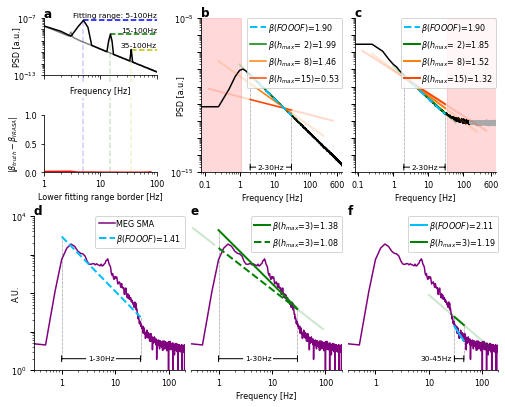

In [13]:
fig = plt.figure(figsize=[fig_width, 5.5], constrained_layout=True)

gs0 = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[1, 1])

gs00 = gs0[0].subgridspec(2, 3, width_ratios=[4, 5, 5])
ax1 = fig.add_subplot(gs00[0, 0])
ax2 = fig.add_subplot(gs00[1, 0])
ax3 = fig.add_subplot(gs00[:, 1])
ax4 = fig.add_subplot(gs00[:, 2])

gs01 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[1])
ax5 = fig.add_subplot(gs01[0])
ax6 = fig.add_subplot(gs01[1])
ax7 = fig.add_subplot(gs01[2])

# a)
# a1
ax = ax1

# Plot sim
ax.loglog(freq_a, sim_psd_a, c_sim)
ax.loglog(freq_ir, psd_aperiodic, c_ap, zorder=0)

# Annotate fitting ranges
vline_dic = dict(ls="--", clip_on=False, alpha=.2)
ymin = yticks_a[0] / 4
for i, (freq_low, color) in enumerate(zip(freqs123, colors123)):
    y = sim_psd_a[freq_low]
    xmin = freq_low
    xmax = upper_fitting_border
    coords = (y, xmin, xmax)
    ax.hlines(*coords, color=color, ls="--")
    v_coords = (xmin, ymin, y)
    ax.vlines(*v_coords, color=color, **vline_dic)

    # Add annotation
    s = f"{freq_low}-{xmax}Hz"
    if i == 0:
        s = "Fitting range: " + s
        y = y**.97
    else:
        y = y**.98
    ax.text(s=s, y=y, **text_dic)

# Set axes
ax.text(s="a", **abc, transform=ax.transAxes)
y_minor = mpl.ticker.LogLocator(subs=np.arange(0, 1, .1), numticks=10)
ax.yaxis.set_minor_locator(y_minor)
ax.set_yticklabels([], minor=True)
ax.set(**axes_a1)
ax.set_ylabel(ylabel_a1, labelpad=-8)

# a2
ax = ax2

# Plot error
ax.semilogx(*error_plot_a)

# Annotate fitting ranges
for i, (freq_low, color) in enumerate(zip(freqs123, colors123)):
    xmin = freq_low
    ymin = 0
    ymax = 1.3
    v_coords = (xmin, ymin, ymax)
    ax.vlines(*v_coords, color=color, **vline_dic)

# Set axes
ax.set(**axes_a2)

# b)
ax = ax3
ax.loglog(freq_b, psd2_noise_b, c_sim)
ax.loglog(*plot_fooof_b, **fooof_kwargs)
for plot_IRASA, IR_kwargs in zip(IR_fit_plot_args_b, IR_fit_plot_kwargs_b):
    ax.loglog(*plot_IRASA, **IR_kwargs)

for plot_IRASA_eff, IR_kwargs_eff in zip(IR_plot_eff_args_b,
                                         IR_plot_eff_kwargs_b):
    ax.loglog(*plot_IRASA_eff, **IR_kwargs_eff)

ax.legend(**tiny_leg)
ax.text(s="b", **abc, transform=ax.transAxes)
ax.set(**axes_b)
ax.set_ylabel(ylabel_a1, labelpad=-15)
ax.tick_params(**ticks_psd)
x_minor = mpl.ticker.LogLocator(subs=np.arange(0, 1, .1), numticks=10)
y_minor = mpl.ticker.LogLocator(subs=np.arange(0, 1, .1), numticks=10)
ax.xaxis.set_minor_locator(x_minor)
ax.yaxis.set_minor_locator(y_minor)
ax.add_patch(plt.Rectangle(**rect_b))

xmin = freq_range[0]
xmax = freq_range[1]
ylow = plot_fooof_b[1][0]
yhigh = plot_fooof_b[1][-1]
height = ylim_b[0] * 2
annotate_range(ax, xmin=xmin, xmax=xmax, ylow=ylow, yhigh=yhigh,
               height=height, annotation="range", annotate_pos=None,
               annotation_fontsize=annotation_fontsize, box_alpha=1)

# c)
ax = ax4
ax.loglog(freq_c[signal_c], psd2_noise_c[signal_c], c_sim)
ax.loglog(freq_c[noise_c], psd2_noise_c[noise_c], c_noise)
ax.loglog(*plot_fooof_c, **fooof_kwargs)
for plot_IRASA, IR_kwargs in zip(IR_fit_plot_args_c, IR_fit_plot_kwargs_c):
    ax.loglog(*plot_IRASA, **IR_kwargs)

for plot_IRASA_eff, IR_kwargs_eff in zip(IR_plot_eff_args_c,
                                         IR_plot_eff_kwargs_c):
    ax.loglog(*plot_IRASA_eff, **IR_kwargs_eff)
ax.legend(**tiny_leg)
ax.set(**axes_c)
ax.text(s="c", **abc, transform=ax.transAxes)
ax.tick_params(**ticks_psd)

x_minor = mpl.ticker.LogLocator(subs=np.arange(0, 1, .1), numticks=10)
y_minor = mpl.ticker.LogLocator(subs=np.arange(0, 1, .1), numticks=10)
ax.xaxis.set_minor_locator(x_minor)
ax.yaxis.set_minor_locator(y_minor)
ax.add_patch(plt.Rectangle(**rect_c))

ylow = plot_fooof_c[1][0]
yhigh = plot_fooof_c[1][-1]
annotate_range(ax, xmin=xmin, xmax=xmax, ylow=ylow, yhigh=yhigh,
               height=height, annotation="range", annotate_pos=None,
               annotation_fontsize=annotation_fontsize, box_alpha=1)


# d)
ax = ax5
ax.loglog(freq, psd_sub, c_real, label="MEG SMA")
ax.loglog(*plot_fooof_low, **fooof_kwargs_low)
ax.legend(**tiny_leg)
ax.tick_params(**ticks_psd)
ax.text(s="d", **abc, transform=ax.transAxes)
ax.set(**axes_d)
ax.set_ylabel("A.U.", labelpad=-10)

xmin = band_low[0]
xmax = band_low[1]
ylow = plot_fooof_low[1][0]
yhigh = plot_fooof_low[1][-1]
height = 2
annotate_range(ax, xmin=xmin, xmax=xmax, ylow=ylow, yhigh=yhigh,
               height=height, annotation="range", annotate_pos=None,
               annotation_fontsize=annotation_fontsize, box_alpha=1)

# e)
ax = ax6
ax.loglog(freq, psd_sub, c_real)

ax.loglog(*plot_IRASA_eff_low_eff, lw=2, label=label_low_eff)  # bold green
ax.loglog(*plot_IRASA_low, lw=2, ls="--", label=label_low)  # dashed green
ax.loglog(*plot_IRASA_eff_low1, alpha=.2, lw=2)  # transparent low
ax.loglog(*plot_IRASA_eff_low2, alpha=.2, lw=2)  # transparent high

ylow = plot_IRASA_eff_low_eff[1][0]
yhigh = plot_IRASA_eff_low_eff[1][-1]
annotate_range(ax, xmin=xmin, xmax=xmax, ylow=ylow, yhigh=yhigh,
               height=height, annotation="range", annotate_pos=None,
               annotation_fontsize=annotation_fontsize, box_alpha=1)

ax.legend(**tiny_leg)
ax.tick_params(**ticks_psd)
ax.text(s="e", **abc, transform=ax.transAxes)
ax.spines["left"].set_visible(False)
ax.set(**axes_e)
ax.set_yticks([], minor=True)

# f)
ax = ax7
ax.loglog(freq, psd_sub, c_real)

ax.loglog(*plot_fooof_high, **fooof_kwargs_high, lw=2, ls="-")
ax.loglog(*plot_IRASA_high, label=label_high, lw=2)
ax.loglog(*plot_IRASA_eff_high, alpha=.2, lw=2)

ax.legend(**tiny_leg)
ax.tick_params(**ticks_psd)
ax.text(s="f", **abc, transform=ax.transAxes)
ax.spines["left"].set_visible(False)
ax.set(**axes_f)
ax.set_yticks([], minor=True)

xmin = band_high[0]
xmax = band_high[1]
ylow = plot_IRASA_high[1][0]
yhigh = plot_IRASA_high[1][-1]

annotate_range(ax, xmin=xmin, xmax=xmax, ylow=ylow, yhigh=yhigh,
               height=height, annotate_pos="left", annotation="range",
               annotation_fontsize=annotation_fontsize)

plt.savefig(fig_path + "Fig5.pdf", bbox_inches="tight")
plt.savefig(fig_path + "Fig5.png", dpi=1000, bbox_inches="tight")
plt.show()